<a href="https://colab.research.google.com/github/LongNguyen1984/DeepLearning/blob/master/EnsembleTutor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

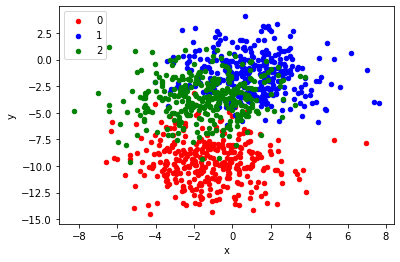

In [ ]:
from sklearn.datasets import make_blobs
from matplotlib import pyplot
from pandas import DataFrame
# generate 2d classification dataset
X, y = make_blobs(n_samples=1000, centers=3, n_features=2, cluster_std=2, random_state=2)
# scatter plot, dots colored by class value
df = DataFrame(dict(x=X[:,0], y=X[:,1],label=y))
colors = {0:'red',1:'blue',2:'green'}
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
  group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
pyplot.show()

In [ ]:
#split into train and test
n_train = int(0.9*X.shape[0])
trainX, testX = X[:n_train,:], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]

Train: 0.829, Test: 0.860


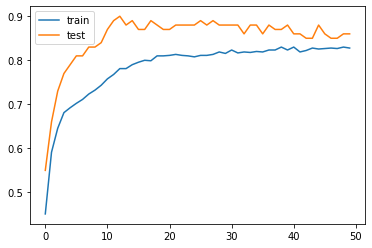

In [ ]:
from sklearn.datasets import make_blobs
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot
# generate 2d classification dataset
X, y = make_blobs(n_samples=1000, centers=3, n_features=2, cluster_std=2, random_state=2)
# one hot encode output variable
y = to_categorical(y)
# split into train and test
n_train = int(0.9 * X.shape[0])
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]
# define model
model = Sequential()
model.add(Dense(50, input_dim=2, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit model
history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=50, verbose=0)
# evaluate the model
_, train_acc = model.evaluate(trainX, trainy, verbose=0)
_, test_acc = model.evaluate(testX, testy, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
# learning curves of model accuracy
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                150       
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 153       
Total params: 303
Trainable params: 303
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# random-splits mlp ensemble on blobs dataset
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot
from numpy import mean
from numpy import std
import numpy
from numpy import array
from numpy import argmax
 
# evaluate a single mlp model
def evaluate_model(trainX, trainy, testX, testy):
	# encode targets
	trainy_enc = to_categorical(trainy)
	testy_enc = to_categorical(testy)
	# define model
	model = Sequential()
	model.add(Dense(50, input_dim=2, activation='relu'))
	model.add(Dense(3, activation='softmax'))
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	# fit model
	model.fit(trainX, trainy_enc, epochs=50, verbose=0)
	# evaluate the model
	_, test_acc = model.evaluate(testX, testy_enc, verbose=0)
	return model, test_acc
 
# make an ensemble prediction for multi-class classification
def ensemble_predictions(members, testX):
	# make predictions
	yhats = [model.predict(testX) for model in members]
	yhats = array(yhats)
	# sum across ensemble members
	summed = numpy.sum(yhats, axis=0)
	# argmax across classes
	result = argmax(summed, axis=1)
	return result
 
# evaluate a specific number of members in an ensemble
def evaluate_n_members(members, n_members, testX, testy):
	# select a subset of members
	subset = members[:n_members]
	# make prediction
	yhat = ensemble_predictions(subset, testX)
	# calculate accuracy
	return accuracy_score(testy, yhat)
 
# generate 2d classification dataset
dataX, datay = make_blobs(n_samples=55000, centers=3, n_features=2, cluster_std=2, random_state=2)
X, newX = dataX[:5000, :], dataX[5000:, :]
y, newy = datay[:5000], datay[5000:]
# multiple train-test splits
n_splits = 10
scores, members = list(), list()
for _ in range(n_splits):
	# split data
	trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.10)
	# evaluate model
	model, test_acc = evaluate_model(trainX, trainy, testX, testy)
	print('>%.3f' % test_acc)
	scores.append(test_acc)
	members.append(model)
# summarize expected performance
print('Estimated Accuracy %.3f (%.3f)' % (mean(scores), std(scores)))
# evaluate different numbers of ensembles on hold out set
single_scores, ensemble_scores = list(), list()
for i in range(1, n_splits+1):
	ensemble_score = evaluate_n_members(members, i, newX, newy)
	newy_enc = to_categorical(newy)
	_, single_score = members[i-1].evaluate(newX, newy_enc, verbose=0)
	print('> %d: single=%.3f, ensemble=%.3f' % (i, single_score, ensemble_score))
	ensemble_scores.append(ensemble_score)
	single_scores.append(single_score)
# plot score vs number of ensemble members
print('Accuracy %.3f (%.3f)' % (mean(single_scores), std(single_scores)))
x_axis = [i for i in range(1, n_splits+1)]
pyplot.plot(x_axis, single_scores, marker='o', linestyle='None')
pyplot.plot(x_axis, ensemble_scores, marker='o')
pyplot.show()

>0.842
>0.816
>0.806
>0.810
>0.832
>0.812
>0.838
>0.824
>0.834
>0.824
Estimated Accuracy 0.824 (0.012)
> 1: single=0.818, ensemble=0.819
> 2: single=0.819, ensemble=0.820
